/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-5-3a44fb5b7cef>:258: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-5-3a44fb5b7cef>:285: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 Batch 0 - Loss: 0.7517
Epoch 1 Batch 50 - Loss: 0.4731
Epoch 1 Batch 100 - Loss: 0.3992
Epoch 1 Batch 150 - Loss: 0.3617
Epoch 1 Batch 200 - Loss: 0.3411
Epoch 1 Batch 250 - Loss: 0.3224
Epoch 1 Batch 300 - Loss: 0.3164
Epoch 1 Batch 350 - Loss: 0.3106


<ipython-input-5-3a44fb5b7cef>:313: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 completed
Train Loss: 0.3737 | Validation Loss: 0.3090
Validation Metrics -> Accuracy: 0.9747, Precision: 0.0350, Recall: 0.4811, F1: 0.0651, IoU: 0.0337
Epoch 2 Batch 0 - Loss: 0.3022
Epoch 2 Batch 50 - Loss: 0.2967
Epoch 2 Batch 100 - Loss: 0.2825
Epoch 2 Batch 150 - Loss: 0.3009
Epoch 2 Batch 200 - Loss: 0.3074
Epoch 2 Batch 250 - Loss: 0.3118
Epoch 2 Batch 300 - Loss: 0.3036
Epoch 2 Batch 350 - Loss: 0.2974
Epoch 2 completed
Train Loss: 0.2925 | Validation Loss: 0.2900
Validation Metrics -> Accuracy: 0.9907, Precision: 0.0559, Recall: 0.2523, F1: 0.0895, IoU: 0.0470
Epoch 3 Batch 0 - Loss: 0.2902
Epoch 3 Batch 50 - Loss: 0.2960
Epoch 3 Batch 100 - Loss: 0.2913
Epoch 3 Batch 150 - Loss: 0.2939
Epoch 3 Batch 200 - Loss: 0.2890
Epoch 3 Batch 250 - Loss: 0.2679
Epoch 3 Batch 300 - Loss: 0.2819
Epoch 3 Batch 350 - Loss: 0.2681
Epoch 3 completed
Train Loss: 0.2820 | Validation Loss: 0.2775
Validation Metrics -> Accuracy: 0.9875, Precision: 0.0593, Recall: 0.3907, F1: 0.1025, IoU:

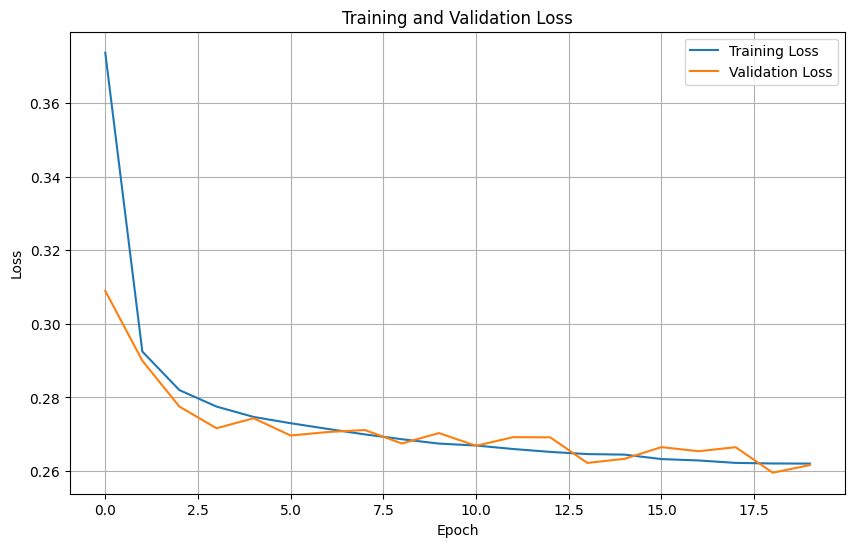

Training completed and model saved!


In [5]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

# Performance improvement: enable cudnn benchmark for fixed input sizes
torch.backends.cudnn.benchmark = True

parent_folder = '/content/drive/MyDrive/hc18'
data_folder = '/content/drive/MyDrive/hc18/data'
validation_set_size = 0.2  # 20% for validation
class HC18(Dataset):
    def __init__(self, train=True, transformX=None, transformY=None):
        # Load the CSV file with pixel size and HC information
        self.pixel_file = pd.read_csv(os.path.join(data_folder, 'training_set_pixel_size_and_HC.csv'))
        self.transformX = transformX
        self.transformY = transformY
        self.train = train

        # Split data into training and validation sets
        self.train_data, self.validation_data = train_test_split(
            self.pixel_file, test_size=validation_set_size, random_state=5
        )

    def __len__(self):
        if self.train:
            return len(self.train_data)
        return len(self.validation_data)

    def __getitem__(self, index):
        # Get file names based on whether it's training or validation
        if self.train:
            imx_name = os.path.join(data_folder, 'training_set', self.train_data.iloc[index, 0])
            imy_name = os.path.join(data_folder, 'training_set',
                                    self.train_data.iloc[index, 0].replace('.png', '_Annotation.png'))
        else:
            imx_name = os.path.join(data_folder, 'training_set', self.validation_data.iloc[index, 0])
            imy_name = os.path.join(data_folder, 'training_set',
                                    self.validation_data.iloc[index, 0].replace('.png', '_Annotation.png'))

        # Open images
        imx = Image.open(imx_name).convert('RGB')  # Ensure input is RGB
        imy = Image.open(imy_name).convert('L')      # Convert to grayscale

        if self.train:
            if random.random() > 0.5:
                imx = TF.hflip(imx)
                imy = TF.hflip(imy)
            if random.random() > 0.5:
                imx = TF.vflip(imx)
                imy = TF.vflip(imy)
            if random.random() > 0.8:
                angle = random.choice([-30, -90, -60, -45, -15, 0, 15, 30, 45, 60, 90])
                imx = TF.rotate(imx, angle)
                imy = TF.rotate(imy, angle)

        if self.transformX:
            imx = self.transformX(imx)
        if self.transformY:
            imy = self.transformY(imy)

        return {'image': imx, 'annotation': imy}

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class NestedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256, 512], deep_supervision=False):
        super(NestedUNet, self).__init__()
        self.deep_supervision = deep_supervision

        # Encoder
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder1 = ConvBlock(in_channels, features[0])
        self.encoder2 = ConvBlock(features[0], features[1])
        self.encoder3 = ConvBlock(features[1], features[2])
        self.encoder4 = ConvBlock(features[2], features[3])
        self.bottom = ConvBlock(features[3], features[4])

        # Nested Decoder X^1_0 (first branch, upsampled once)
        self.up1_0 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.conv1_0 = ConvBlock(features[0] * 2, features[0])

        # Nested Decoder X^2_0 (second branch, upsampled twice)
        self.up2_0 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.conv2_0 = ConvBlock(features[1] * 2, features[1])
        self.up1_1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.conv1_1 = ConvBlock(features[0] * 3, features[0])

        # Nested Decoder X^3_0 (third branch, upsampled three times)
        self.up3_0 = nn.ConvTranspose2d(features[3], features[2], kernel_size=2, stride=2)
        self.conv3_0 = ConvBlock(features[2] * 2, features[2])
        self.up2_1 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.conv2_1 = ConvBlock(features[1] * 3, features[1])
        self.up1_2 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.conv1_2 = ConvBlock(features[0] * 4, features[0])

        # Nested Decoder X^4_0 (fourth branch, upsampled four times)
        self.up4_0 = nn.ConvTranspose2d(features[4], features[3], kernel_size=2, stride=2)
        self.conv4_0 = ConvBlock(features[3] * 2, features[3])
        self.up3_1 = nn.ConvTranspose2d(features[3], features[2], kernel_size=2, stride=2)
        self.conv3_1 = ConvBlock(features[2] * 3, features[2])
        self.up2_2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.conv2_2 = ConvBlock(features[1] * 4, features[1])
        self.up1_3 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.conv1_3 = ConvBlock(features[0] * 5, features[0])

        # Final outputs for deep supervision
        self.final1 = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.final2 = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.final3 = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.final4 = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.encoder1(x)
        x2 = self.encoder2(self.pool(x1))
        x3 = self.encoder3(self.pool(x2))
        x4 = self.encoder4(self.pool(x3))
        x5 = self.bottom(self.pool(x4))

        # Decoder path 1
        up4_0 = self.up4_0(x5)
        merge4_0 = torch.cat([up4_0, x4], dim=1)
        conv4_0 = self.conv4_0(merge4_0)

        up3_0 = self.up3_0(x4)
        merge3_0 = torch.cat([up3_0, x3], dim=1)
        conv3_0 = self.conv3_0(merge3_0)
        up3_1 = self.up3_1(conv4_0)
        merge3_1 = torch.cat([up3_1, conv3_0, x3], dim=1)
        conv3_1 = self.conv3_1(merge3_1)

        up2_0 = self.up2_0(x3)
        merge2_0 = torch.cat([up2_0, x2], dim=1)
        conv2_0 = self.conv2_0(merge2_0)
        up2_1 = self.up2_1(conv3_0)
        merge2_1 = torch.cat([up2_1, conv2_0, x2], dim=1)
        conv2_1 = self.conv2_1(merge2_1)
        up2_2 = self.up2_2(conv3_1)
        merge2_2 = torch.cat([up2_2, conv2_1, conv2_0, x2], dim=1)
        conv2_2 = self.conv2_2(merge2_2)

        up1_0 = self.up1_0(x2)
        merge1_0 = torch.cat([up1_0, x1], dim=1)
        conv1_0 = self.conv1_0(merge1_0)
        up1_1 = self.up1_1(conv2_0)
        merge1_1 = torch.cat([up1_1, conv1_0, x1], dim=1)
        conv1_1 = self.conv1_1(merge1_1)
        up1_2 = self.up1_2(conv2_1)
        merge1_2 = torch.cat([up1_2, conv1_1, conv1_0, x1], dim=1)
        conv1_2 = self.conv1_2(merge1_2)
        up1_3 = self.up1_3(conv2_2)
        merge1_3 = torch.cat([up1_3, conv1_2, conv1_1, conv1_0, x1], dim=1)
        conv1_3 = self.conv1_3(merge1_3)

        # Final outputs
        final4 = self.final4(conv1_3)
        final3 = self.final3(conv1_2)
        final2 = self.final2(conv1_1)
        final1 = self.final1(conv1_0)

        if self.deep_supervision:
            return final4, final3, final2, final1
        else:
            return final4

def dice_loss(pred, target):
    smooth = 1.0
    pred = torch.sigmoid(pred)
    if pred.shape != target.shape:
        if len(pred.shape) > len(target.shape):
            target = target.unsqueeze(1)
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def compute_metrics(pred, target):
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    TP = ((pred_flat == 1) & (target_flat == 1)).sum().item()
    TN = ((pred_flat == 0) & (target_flat == 0)).sum().item()
    FP = ((pred_flat == 1) & (target_flat == 0)).sum().item()
    FN = ((pred_flat == 0) & (target_flat == 1)).sum().item()

    total = TP + TN + FP + FN
    accuracy = (TP + TN) / total if total > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0

    return accuracy, precision, recall, f1, iou

# Define transformations
transform_input = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_mask = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Create dataset instances
train_dataset = HC18(train=True, transformX=transform_input, transformY=transform_mask)
validation_dataset = HC18(train=False, transformX=transform_input, transformY=transform_mask)

# Create data loaders with additional optimizations
train_loader = DataLoader(dataset=train_dataset, batch_size=2, shuffle=True, num_workers=4, pin_memory=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)

# Initialize model and optimizer
model = NestedUNet(in_channels=3, out_channels=1, features=[32, 64, 128, 256, 512], deep_supervision=False)
model = model.to("cuda")
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define BCE loss with logits
criterion = nn.BCEWithLogitsLoss()

# Set up mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

# Training loop
epochs = 20
train_running_loss_history = []
validation_running_loss_history = []

for e in range(epochs):
    train_running_loss = 0.0
    validation_running_loss = 0.0
    total_acc, total_prec, total_rec, total_f1, total_iou = 0, 0, 0, 0, 0
    metric_batches = 0

    model.train()
    for ith_batch, sample_batched in enumerate(train_loader):
        X_train = sample_batched['image'].to("cuda")
        y_train = sample_batched['annotation'].to("cuda")
        if y_train.shape[1] != 1:
            if y_train.shape[1] == 3 and torch.all(y_train[:, 0, :, :] == y_train[:, 1, :, :]) and torch.all(y_train[:, 0, :, :] == y_train[:, 2, :, :]):
                y_train = y_train[:, 0:1, :, :]
            elif len(y_train.shape) == 3:
                y_train = y_train.unsqueeze(1)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            y_pred = model(X_train)
            if y_pred.shape != y_train.shape:
                if y_pred.shape[1] > 1 and y_train.shape[1] == 1:
                    y_pred = y_pred[:, 0:1, :, :]
            loss = 0.30 * dice_loss(y_pred, y_train) + 0.70 * criterion(y_pred, y_train)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if ith_batch % 50 == 0:
            print(f"Epoch {e+1} Batch {ith_batch} - Loss: {loss.item():.4f}")

        train_running_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for ith_batch, sample_batched in enumerate(validation_loader):
            X_val = sample_batched['image'].to("cuda")
            y_val = sample_batched['annotation'].to("cuda")
            if y_val.shape[1] != 1:
                if y_val.shape[1] == 3 and torch.all(y_val[:, 0, :, :] == y_val[:, 1, :, :]) and torch.all(y_val[:, 0, :, :] == y_val[:, 2, :, :]):
                    y_val = y_val[:, 0:1, :, :]
                elif len(y_val.shape) == 3:
                    y_val = y_val.unsqueeze(1)
            with torch.cuda.amp.autocast():
                y_out = model(X_val)
                if y_out.shape != y_val.shape:
                    if y_out.shape[1] > 1 and y_val.shape[1] == 1:
                        y_out = y_out[:, 0:1, :, :]

                # Compute loss on raw output for validation
                val_loss = 0.30 * dice_loss(y_out, y_val) + 0.70 * criterion(y_out, y_val)
            validation_running_loss += val_loss.item()

            # Threshold the predictions to get binary segmentation masks
            out_val = (torch.sigmoid(y_out) > 0.5).float()
            # Compute additional metrics for this batch
            acc, prec, rec, f1, iou = compute_metrics(out_val, y_val)
            total_acc   += acc
            total_prec  += prec
            total_rec   += rec
            total_f1    += f1
            total_iou   += iou
            metric_batches += 1

    train_epoch_loss = train_running_loss / len(train_loader)
    validation_epoch_loss = validation_running_loss / len(validation_loader)
    avg_acc   = total_acc / metric_batches
    avg_prec  = total_prec / metric_batches
    avg_rec   = total_rec / metric_batches
    avg_f1    = total_f1 / metric_batches
    avg_iou   = total_iou / metric_batches

    print(f"Epoch {e+1} completed")
    print(f"Train Loss: {train_epoch_loss:.4f} | Validation Loss: {validation_epoch_loss:.4f}")
    print(f"Validation Metrics -> Accuracy: {avg_acc:.4f}, Precision: {avg_prec:.4f}, Recall: {avg_rec:.4f}, F1: {avg_f1:.4f}, IoU: {avg_iou:.4f}")
    train_running_loss_history.append(train_epoch_loss)
    validation_running_loss_history.append(validation_epoch_loss)
    torch.cuda.empty_cache()

plt.figure(figsize=(10, 6))
plt.plot(train_running_loss_history, label='Training Loss')
plt.plot(validation_running_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_history.png')
plt.show()

torch.save(model.state_dict(), 'unetpp_hc18_final.pth')
print("Training completed and model saved!")

def visualize_predictions(model, data_loader, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i >= num_samples:
                break
            images = batch['image'].to('cuda')
            masks = batch['annotation'].to('cuda')
            if len(masks.shape) == 3:
                masks = masks.unsqueeze(1)
            outputs = model(images)
            if outputs.shape != masks.shape:
                if outputs.shape[1] > 1 and masks.shape[1] == 1:
                    outputs = outputs[:, 0:1, :, :]
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            # Denormalize image for visualization
            image = images[0].cpu().permute(1, 2, 0).numpy()
            image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            image = np.clip(image, 0, 1)
            mask = masks[0, 0].cpu().numpy()
            pred = predictions[0, 0].cpu().numpy()
            axes[i, 0].imshow(image)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')
            axes[i, 1].imshow(mask, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            axes[i, 2].imshow(pred, cmap='gray')
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')
    plt.tight_layout()
    plt.savefig('unetpp_predictions.png')
    plt.show()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


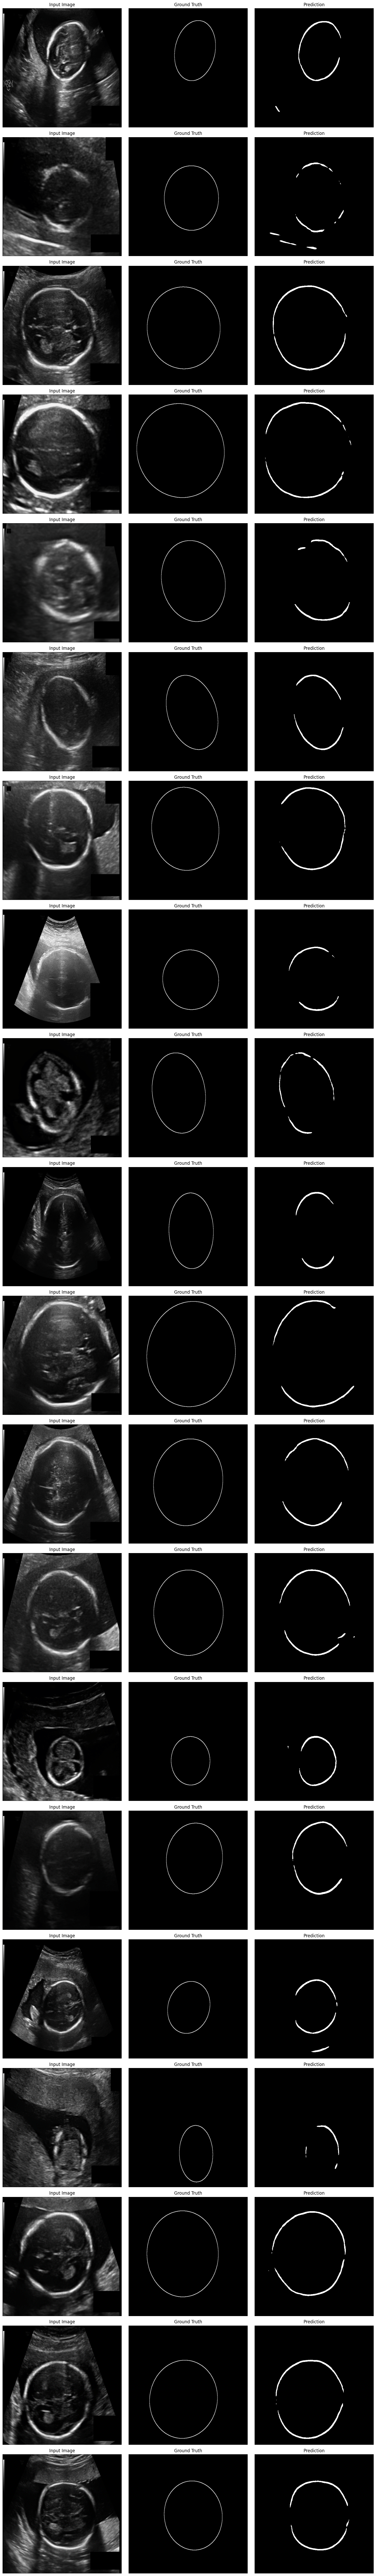

In [7]:
visualize_predictions(model, validation_loader, num_samples=20)